# 'Fit_statistics.ipynb' is created by Yue on Feb 12, 2024 for computing specific statistics.

Workflow:
1. Load basic statistics, masks and datetime.
2. Fit the u_avg profile.
3. Determine ISL.
4. Fit the u_std profile.
5. Fit w_std against u_star.
6. Compute IST for u, wdir
7. Compute index for ISL and wind shear

Notes:
1. input directory: /save_mask_data, /save_statistical_data.
2. output directory: /save_fitted_data.
3. Some mean wind profiles can have negative slope, which will not produce z_0.
4. datetime_all files contain hours from 0 to 23.
5. Results from fitting u_avg profile are saved in f"{level}_u_avg_fitting_1Ddata.pkl" and "f{level}_u_avg_fitting_2Ddata.pkl". Different ranges of u_avg are used to determine the ISL.
6. After deciding to use 5th to 11th levels as ISL, results are saved in "u_std_fitting_1Ddata.pkl" and "u_std_fitting_2Ddata.pkl".
7. index_shear has a shape of [n_hours,sonum-1]

=========== Disable de-spike on Sep 14, 2024 and save data to /save_fitted_data_091424 =====

=========== Disable de-spike and do planar fit on Sep 19, 2024 and save data to /save_fitted_data_planarfit =====

=========== Disable de-spike and do planar fit on Sep 19, 2024 and save data to /save_fitted_data_092024 =====

*** Add azimuth correction for each sensor on Oct 1, 2024 

=========== Disable de-spike and do double rotation on Oct 1, 2024 and save data to /save_processed_data_2rot =====

# Set up environment

In [1]:
# import packages
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os.path
import time
from matplotlib.pyplot import figure
import scipy.io as sio
from datetime import date, timedelta
from math import *
from scipy.stats import gmean
from scipy import ndimage
from scipy import stats
from scipy import signal
import matplotlib.transforms as mtransforms
import seaborn as sns
import pickle

# Set up parameters

In [9]:
# directories
IN_DIR = "/projectnb/urbanclimate/yueqin/idaho_ec_jupyter/save_statistical_data_091424/"
IN_MSK_DIR = "/projectnb/urbanclimate/yueqin/idaho_ec_jupyter/save_mask_data_091424/"
IN_INS_DIR = "/projectnb/urbanclimate/yueqin/idaho_ec_jupyter/save_processed_data_091424/"

OUT_DIR = "/projectnb/urbanclimate/yueqin/idaho_ec_jupyter/save_fitted_data_091424/"
OUT_PLOT_DIR = "/projectnb/urbanclimate/yueqin/idaho_ec_jupyter/save_fig_2rot/"

# List of directories to check
directories = [IN_DIR, IN_MSK_DIR, IN_INS_DIR, OUT_DIR, OUT_PLOT_DIR]

# Check if directories exist, create them if they don't
for dir_path in directories:
    if not os.path.exists(dir_path):
        try:
            os.makedirs(dir_path)
            print(f"Created directory: {dir_path}")
        except Exception as e:
            print(f"An error occurred while creating directory {dir_path}: {e}")
    else:
        print(f"Directory exists: {dir_path}")

# labels
list_bot = np.array([0,1,2,3,4]) # bottom five levels
list_all = np.arange(0, 12, 1)
list_sel = np.array([5,6,7,8,9,10]) # from level 6 to level 11
list_test1 = np.array([4,5,6,7,8,9,10,11])
list_test2 = np.array([4,5,6,7,8,9,10])
list_test3 = np.array([5,6,7,8,9,10,11])

# global constants
sonum    =12                       # number of sonic
z  = np.array([1.2,2,3.5,6,9,12.5,16.5,23,30,40,50,60])  # height of sonic above ground, 
frequency=10                   # sampling rate, Hz
time_avg =3600                  # average time, s

# physical constants (or values that are assumed constant)
Rw  = 461.5     # ideal gas constant for water vapor, J/kg*K
Rd  = 287.05    # ideal gas constant for dry air, J/kg*K
Lv  = 1000*2257 # latent heat of vaporization (water), J/kg
Cp  = 1005      # approximate constant pressure specific heat of air, J/kg*K
kappa_assumed = 0.4 # von karman constant
g   = 9.81      # acceleration of gravity, m/s^2
nu = 1.48 * 10**(-5) # kinematic viscosity, m2 /s


# plotting
font_size = 10
mark_size = 5
plt.rc('text', usetex=True)
# plt.rc('font', family='sans-serif')
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.weight"] = "bold"
plt.rc('xtick', labelsize=font_size) 
plt.rc('ytick', labelsize=font_size)
# label physical distance in and down:
# trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)

# input variables
in_avg = ['wind_ang_all','u_avg_ldtr', 'u_avg_filt']
in_std = ['u_std_ldtr', 'u_std_filt','w_std_ldtr', 'w_std_filt']
in_flux = ['u_star_ldtr', 'H_ldtr', 'u_star_filt', 'H_filt']
in_stability = ['L_H2_ldtr', 'stability_ldtr', 'L_H2_filt', 'stability_filt']
in_mask = ['mask_rnan', 'mask_dspk', 'mask_neutral', 'mask_wdir', 'mask_taylor',
           'mask_ustar_gt005', 'mask_H_gt10']
in_tur = ['u_dspk_2rot_ldtr', 'u_dspk_2rot_filt', 'ux_dspk', 'uy_dspk']
# Define detrending types
var_types = ['ldtr', 'filt']

Directory exists: /projectnb/urbanclimate/yueqin/idaho_ec_jupyter/save_statistical_data_091424/
Directory exists: /projectnb/urbanclimate/yueqin/idaho_ec_jupyter/save_mask_data_091424/
Directory exists: /projectnb/urbanclimate/yueqin/idaho_ec_jupyter/save_processed_data_091424/
Directory exists: /projectnb/urbanclimate/yueqin/idaho_ec_jupyter/save_fitted_data_091424/
Directory exists: /projectnb/urbanclimate/yueqin/idaho_ec_jupyter/save_fig_2rot/


# Define functions

In [3]:
def ist_wspd_10min(data):
    """
    Return the non-stationarity index for every hourly time series 
    """
    data_10min = data.reshape([6,-1]) # split each hour into 6 chunks/every 10 min
    cvm = np.nanmean(np.nanvar(data_10min,axis=1)) # avg of the variance of each chunck
    # print(np.nanvar(data_10min,axis=1))
    # print(cvm)
    ist_10min = abs(cvm-np.nanvar(data))/np.nanvar(data)
    return ist_10min

def ist_wspd_5min(data):
    """
    Return the non-stationarity index for every hourly time series 
    """
    data_5min = data.reshape([12,-1]) # split each hour into 12 chunks/every 5 min
    cvm = np.nanmean(np.nanvar(data_5min,axis=1)) # avg of the variance of each chunck
    # print(np.nanvar(data_10min,axis=1))
    # print(cvm)
    ist_5min = abs(cvm-np.nanvar(data))/np.nanvar(data)
    return ist_5min

def convert_ang(wdir,nl):
    """
    Convert wind direction from [0,360] to [-180,180]
    nl=2->2Darray; nl=1->1Darray, nl=0->0D
    """
    if nl==2:
        wdir_new = wdir.copy()
        wdir_new[wdir>180] = wdir_new[wdir>180] - 360
        wdir_new[wdir<-180] = wdir_new[wdir<-180] + 360
    if nl==1:
        wdir_new = wdir.copy()
        for i in range(len(wdir)):
            if wdir[i]>180:
                wdir_new[i] = wdir[i] - 360
            if wdir[i]<-180:
                wdir_new[i] = wdir[i] + 360
            # else:
            #     wdir_new[i] = wdir[i]
    if nl==0:
        if wdir>180:
            wdir_new = wdir - 360
        if wdir<-180:
            wdir_new = wdir + 360
        else:
            wdir_new = wdir
    return wdir_new

def get_wind_ang(ux,uy,nl):
    """
    For 1 level only
    Calculate mean wind angle on the xy-plane (!! must do before double rotation)
    The CSAT3 (the anemometer arms, tripods) is aligned northward and if u is positive, the wind is northerly. 
    If v is positive, the wind is westerly.
    u:north(+)->south(-), v:west(+)->east(-)
    """
    u_avg = np.nanmean(ux,axis=0) # size = 1
    v_avg = np.nanmean(uy,axis=0)
    rot_ang_v = degrees(np.arctan(v_avg/u_avg))      
    if nl==1:
        wind_ang = rot_ang_v
        if np.logical_and(u_avg>=0, v_avg<=0):
            wind_ang = -rot_ang_v # northeast
        if np.logical_and(u_avg<=0, v_avg<=0):
            wind_ang = 180-rot_ang_v # southest
        if np.logical_and(u_avg<=0, v_avg>=0):
            wind_ang = 180-rot_ang_v # southwest
        if np.logical_and(u_avg>=0, v_avg>=0):
            wind_ang = 360-rot_ang_v # northwest 
    return wind_ang

def ist_wdir(u_ins,v_ins,wind_ang_1hr):
    """
    Calculate IST(wdir) = |wdir5min-wdir1hr|max
    """
    u_ins_5min = u_ins.reshape([12,-1]) # split each hour into 12 chunks/every 5 min
    v_ins_5min = v_ins.reshape([12,-1]) # split each hour into 12 chunks/every 5 min
    # calculate 5 min wind angle
    wind_ang_temp = np.zeros(12)*np.nan
    # print(wind_ang_1hr)
    for i in range(12): # 12 chunks
        # print(i)
        wind_ang_temp[i] = get_wind_ang(u_ins_5min[i,:],v_ins_5min[i,:],1)
    # print('before-----------------')
    # print(wind_ang_temp)
    wind_ang_5min = convert_ang(wind_ang_temp,1) # convert wind direction to [-180,180]  
    # print('after-----------------')
    # print(wind_ang_5min)
    diff_temp = abs(wind_ang_5min-wind_ang_1hr)
    wdir_diff_max = np.nanmax(diff_temp)
    return wdir_diff_max

def get_uavg_fit(_z,_uavg):
    """
    Compute u_star or kappa by fitting the mean wind profile
    note that it might have some wierd profiles
    e.g. negative slope -> can't calculate z0
    
    """
    mask1 = ~np.isnan(_z)
    mask2 = ~np.isnan(_uavg)
    mask = np.logical_and(mask1,mask2) # mask out nan values
    slope_,intercept_,r_,_,_ = stats.linregress(np.log(_z[mask]), _uavg[mask])
    r2_ = r_**2 # r-square value
    # print(slope_,intercept_,r_)
    # print(-intercept_/slope_)
    if slope_ <= 0.1 :
        # print('negative slope in u_avg profile')
        return slope_,intercept_,r2_,np.nan
    else:
        # print(intercept_,slope_)
        z0_ = exp(-intercept_/slope_) # momentum roughness length           
        return slope_,intercept_,r2_,z0_

def get_ustd_fit_backup(_z,_y):
    """
    Compute Townsend's coefficient A1 by fitting the streamwise velocity variance.
    Because I use -log(z) to fit agianst u_std^2/u_star^2, the slope is positive and is equal to A1_fit.
    """
    mask1 = ~np.isnan(_z)
    mask2 = ~np.isnan(_y)
    mask = np.logical_and(mask1,mask2) # mask out nan values
    rsl = stats.linregress(-np.log(_z[mask]), _y[mask])
    A1_ = rsl.slope
    r2_A1_ = rsl.rvalue**2
    return A1_,r2_A1_

def get_ustd_fit(_z,_y):
    """
    Compute Townsend's coefficient A1 by fitting the streamwise velocity variance.
    Because I use -log(z) to fit agianst u_std^2/u_star^2, the slope is positive and is equal to A1_fit.
    """
    mask1 = ~np.isnan(_z)
    mask2 = ~np.isnan(_y)
    mask = np.logical_and(mask1,mask2) # mask out nan values
    rsl = stats.linregress(np.log(_z[mask]), _y[mask])
    slope_ = rsl.slope
    r2_ = rsl.rvalue**2
    intercept_ = rsl.intercept
    return slope_, intercept_, r2_

def calculate_u_star_means_and_uavg_fits(levels, types, index):
    for level in levels:
        if level == 'all_level':
            range_ = list_all
        elif level == 'sel_level':
            range_ = list_sel
        elif level == 'test1':
            range_ = list_test1
        elif level == 'test2':
            range_ = list_test2
        elif level == 'test3':
            range_ = list_test3
            
        for type_ in types:
            # Calculate u_star mean
            if type_ == 'ldtr':
                var1d[level][type_]['u_star_mean'][index] = np.nanmean(u_star_ldtr[index, range_])
            elif type_ == 'filt':
                var1d[level][type_]['u_star_mean'][index] = np.nanmean(u_star_filt[index, range_])
            
            # Update fits
            (var1d[level][type_]['slope_uavg'][index], 
             var1d[level][type_]['intercept_uavg'][index], 
             var1d[level][type_]['r2_uavg'][index], 
             var1d[level][type_]['z0_fit'][index]) = get_uavg_fit(z[range_], globals()[f'u_avg_{type_}'][index, range_])
            
            # Calculate kappa_fit
            var1d[level][type_]['kappa_fit'][index] = var1d[level][type_]['u_star_mean'][index] / var1d[level][type_]['slope_uavg'][index]
            
            # Calculate u_star_fit
            var1d[level][type_]['u_star_fit'][index] = kappa_assumed * var1d[level][type_]['slope_uavg'][index]

def calculate_u_star_vertical_diff(levels, types, index):
    """ 
    u_star_dev = (u_star-u_star_mean)/u_star_mean
    u_star_diff = (u_star-u_star_fit)/u_star_fit
    """
    for level in levels:
        for type_ in types:
            if type_ == 'ldtr':
                var2d[level][type_]['u_star_dev'][index,:] = (u_star_ldtr[index,:] - var1d[level][type_]['u_star_mean'][index])/var1d[level][type_]['u_star_mean'][index]
                var2d[level][type_]['u_star_diff'][index,:] = (u_star_ldtr[index,:] - var1d[level][type_]['u_star_fit'][index])/var1d[level][type_]['u_star_fit'][index]
            elif type_ == 'filt':
                var2d[level][type_]['u_star_dev'][index,:] = (u_star_filt[index,:] - var1d[level][type_]['u_star_mean'][index])/var1d[level][type_]['u_star_mean'][index]
                var2d[level][type_]['u_star_diff'][index,:] = (u_star_filt[index,:] - var1d[level][type_]['u_star_fit'][index])/var1d[level][type_]['u_star_fit'][index]

def cal_stability_corrected_kappa(type_, index):
    """
    Use Businger-Dyer equations to estimate the stability correction function
    """
    if varISL_1d[type_]['stability_parameter'][index] > 0: # stable condition
        varISL_1d[type_]['kappa_corrected'][index] = var1d['sel_level'][type_]['kappa_fit'][index]*(1+5*varISL_1d[type_]['stability_parameter'][index]) 
    else: # unstable condition
        varISL_1d[type_]['kappa_corrected'][index] = var1d['sel_level'][type_]['kappa_fit'][index]*(1-16*varISL_1d[type_]['stability_parameter'][index])**(-1/4)

def cal_ustd_fits_backup(type_, index):
    # Normalize u_std by u_star_mean
    y_u_std = globals()[f'u_std_{type_}'][index,list_sel]**2 / (var1d['sel_level'][type_]['u_star_mean'][index]**2)
    # Update fits
    varISL_1d[type_]['A1_fit'][index],varISL_1d[type_]['r2_ustd'][index] = get_ustd_fit(z[list_sel],y_u_std)
    
def cal_ustd_fits(type_, index):
    # Normalize u_std by u_star_mean
    y_u_std = globals()[f'u_std_{type_}'][index,list_sel]**2 / (var1d['sel_level'][type_]['u_star_mean'][index]**2)
    # Update fits
    varISL_1d[type_]['slope_ustd'][index],varISL_1d[type_]['intercept_ustd'][index],varISL_1d[type_]['r2_ustd'][index] = get_ustd_fit(z[list_sel],y_u_std)
    varISL_1d[type_]['A1_fit'][index] = -varISL_1d[type_]['slope_ustd'][index]

# Function to calculate slope with intercept forced to 0
# def cal_wstd_fits_through_origin(type_, index):
#     y = globals()[f'w_std_{type_}'][index, list_sel]
#     x = globals()[f'u_star_{type_}'][index, list_sel]
    
#     # Mask out nan values
#     mask1 = ~np.isnan(x)
#     mask2 = ~np.isnan(y)
#     mask = np.logical_and(mask1, mask2)
    
#     # Filter x and y with the mask
#     x_filtered = x[mask]
#     y_filtered = y[mask]
    
#     # Reshape x_filtered to match the requirement of np.linalg.lstsq
#     x_filtered = x_filtered.reshape(-1, 1)
    
#     # Perform linear regression with intercept forced to 0
#     slope_, _, _, _ = np.linalg.lstsq(x_filtered, y_filtered, rcond=None)
    
#     # Calculate R-squared (coefficient of determination)
#     y_pred = x_filtered * slope_
#     ss_tot = np.sum((y_filtered - np.mean(y_filtered))**2)
#     ss_res = np.sum((y_filtered - y_pred)**2)
#     r2_ = 1 - (ss_res / ss_tot)
#     print(r2_)

#     # Store results
#     varISL_1d[type_]['slope_wstd_ustar'][index] = slope_
#     varISL_1d[type_]['r2_wstd'][index] = r2_

def cal_wstd_fits_through_origin(type_, index):
    """
    Fit the slope of w_std^2 over u_star^2 within ISL
    """
    y = (globals()[f'w_std_{type_}'][index, list_sel])**2
    x = (globals()[f'u_star_{type_}'][index, list_sel])**2
    
    # Mask out nan values
    mask1 = ~np.isnan(x)
    mask2 = ~np.isnan(y)
    mask = np.logical_and(mask1, mask2)
    
    # Filter x and y with the mask
    x_filtered = x[mask]
    y_filtered = y[mask]
    
    # Perform linear regression with intercept forced to 0
    slope_, _, _, _ = np.linalg.lstsq(x_filtered[:, np.newaxis], y_filtered, rcond=None)
    
    # Calculate predicted values
    y_pred = x_filtered * slope_
    
    # Calculate the total sum of squares (ss_tot) and residual sum of squares (ss_res)
    ss_tot = np.sum(y_filtered**2)  # Since regression is through the origin, use the sum of squares of y
    ss_res = np.sum((y_filtered - y_pred)**2)
    
    # Calculate R^2 (coefficient of determination)
    r2_ = 1 - (ss_res / ss_tot)
    
    # Store results
    varISL_1d[type_]['slope_wstd_ustar'][index] = slope_[0]
    varISL_1d[type_]['r2_wstd'][index] = r2_

    print(f"Slope: {slope_[0]}, R-squared: {r2_}")

# load necessary variables
also load n_hours, masks, datetime

In [4]:
for var_name in in_avg+in_std+in_flux+in_stability:
    globals()[var_name] = np.load(f"{IN_DIR}{var_name}.npy")
for var_name in in_mask:
    globals()[var_name] = np.load(f"{IN_MSK_DIR}{var_name}.npy")

mask = mask_rnan*mask_dspk*mask_neutral*mask_wdir*mask_taylor*mask_ustar_gt005
n_hours = np.load(f"{IN_DIR}{'n_hours'}.npy")
# mask_rnan = np.load(f"{IN_MSK_DIR}{'mask_rnan'}.npy")
datetime_all = np.load(f"{IN_DIR}{'datetime_all'}.npy", allow_pickle=True)
write_results = True
OUT_DIR

'/projectnb/urbanclimate/yueqin/idaho_ec_jupyter/save_fitted_data_091424/'

# Determine the inertial sublayer
Fit u_avg with different vertical range and compare the fitted kappa.

In [5]:
# Define variable names
var1d_names = ['u_star_mean', 'kappa_fit', 'u_star_fit', 'slope_uavg', 'intercept_uavg', 'r2_uavg', 'z0_fit']
var2d_names = ['u_star_dev','u_star_diff']

# Define level names
var1d_levels = ['all_level','sel_level','test1','test2','test3']
var2d_levels = ['all_level','sel_level','test1','test2','test3']

# Initialize all variables using nested dictionary comprehensions
var1d = {level: {type_: {name: np.zeros(n_hours) * np.nan for name in var1d_names} 
               for type_ in var_types} for level in var1d_levels}
# var2d_levels = ['all_level','sel_level']
var2d = {level: {type_: {name: np.zeros((n_hours,sonum))*np.nan for name in var2d_names} 
               for type_ in var_types} for level in var2d_levels}

# Calculate mean u_star and vertical deviation

In [66]:
n_hours

array(5040)

In [68]:
%%time
for i in range(n_hours):
    if mask_rnan[i]: # skip nan hours
        # Estimate u_star by vertically averaged
        # Fit uavg profiles to get fitted kappa
        calculate_u_star_means_and_uavg_fits(var1d_levels, var_types, i)
        # Calculate vertical deviation
        calculate_u_star_vertical_diff(var2d_levels, var_types, i)

# Save results
if write_results:
    # save all levels together
    filename = "u_avg_fitting_1Ddata.pkl"
    with open(OUT_DIR + filename, 'wb') as f:
        pickle.dump(var1d, f)
    filename = "u_avg_fitting_2Ddata.pkl"
    with open(OUT_DIR + filename, 'wb') as f:
        pickle.dump(var2d, f)
    # Separate dictionary by levels
    for level in var1d_levels:
        data_to_save = var1d[level]
        filename = f"{level}_u_avg_fitting_1Ddata.pkl"
        with open(OUT_DIR + filename, 'wb') as f:
            pickle.dump(data_to_save, f)
            
    for level in var2d_levels:
        data_to_save = var2d[level]
        filename = f"{level}_u_avg_fitting_2Ddata.pkl"
        with open(OUT_DIR + filename, 'wb') as f:
            pickle.dump(data_to_save, f)

CPU times: user 12.2 s, sys: 0 ns, total: 12.2 s
Wall time: 12.5 s


# Load output data

In [5]:
filename = "u_avg_fitting_1Ddata.pkl"
var1d = np.load(OUT_DIR + filename, allow_pickle=True)
filename = "u_avg_fitting_2Ddata.pkl"
var2d = np.load(OUT_DIR + filename, allow_pickle=True)

IN_MSK_DIR = "/projectnb/urbanclimate/yueqin/idaho_ec_jupyter/save_mask_data_091424/"
in_mask = ['mask_rnan', 'mask_dspk', 'mask_neutral', 'mask_wdir', 'mask_taylor',
           'mask_ustar_gt005', 'mask_H_gt10']
for var_name in in_mask:
    globals()[var_name] = np.load(f"{IN_MSK_DIR}{var_name}.npy")
    
IN_STAT_DIR = "/projectnb/urbanclimate/yueqin/idaho_ec_jupyter/save_statistical_data_091424/"    
in_avg = ['u_avg_ldtr', 'u_avg_filt', 'Rho_air', 'P_avg', 'stability_filt']
for var_name in in_avg:
    globals()[var_name] = np.load(f"{IN_STAT_DIR}{var_name}.npy", allow_pickle=True)

Rho_air_mean = np.nanmean(Rho_air[:,list_sel],axis=1)
mask_rho = Rho_air_mean<1.25    
mask1 = mask_rnan*mask_neutral*mask_wdir*mask_taylor*mask_rho

In [70]:
var2d['all_level']['ldtr']['u_star_dev'].shape,mask1.shape

((5040, 12), (5040,))

In [72]:
np.sum(mask1)

120

# Plot Vertical profile of the locally measured u*

## Linear detrend

In [73]:
np.sum(mask1)

120

In [76]:
OUT_PLOT_DIR

'/projectnb/urbanclimate/yueqin/idaho_ec_jupyter/save_fig_planarfit/'

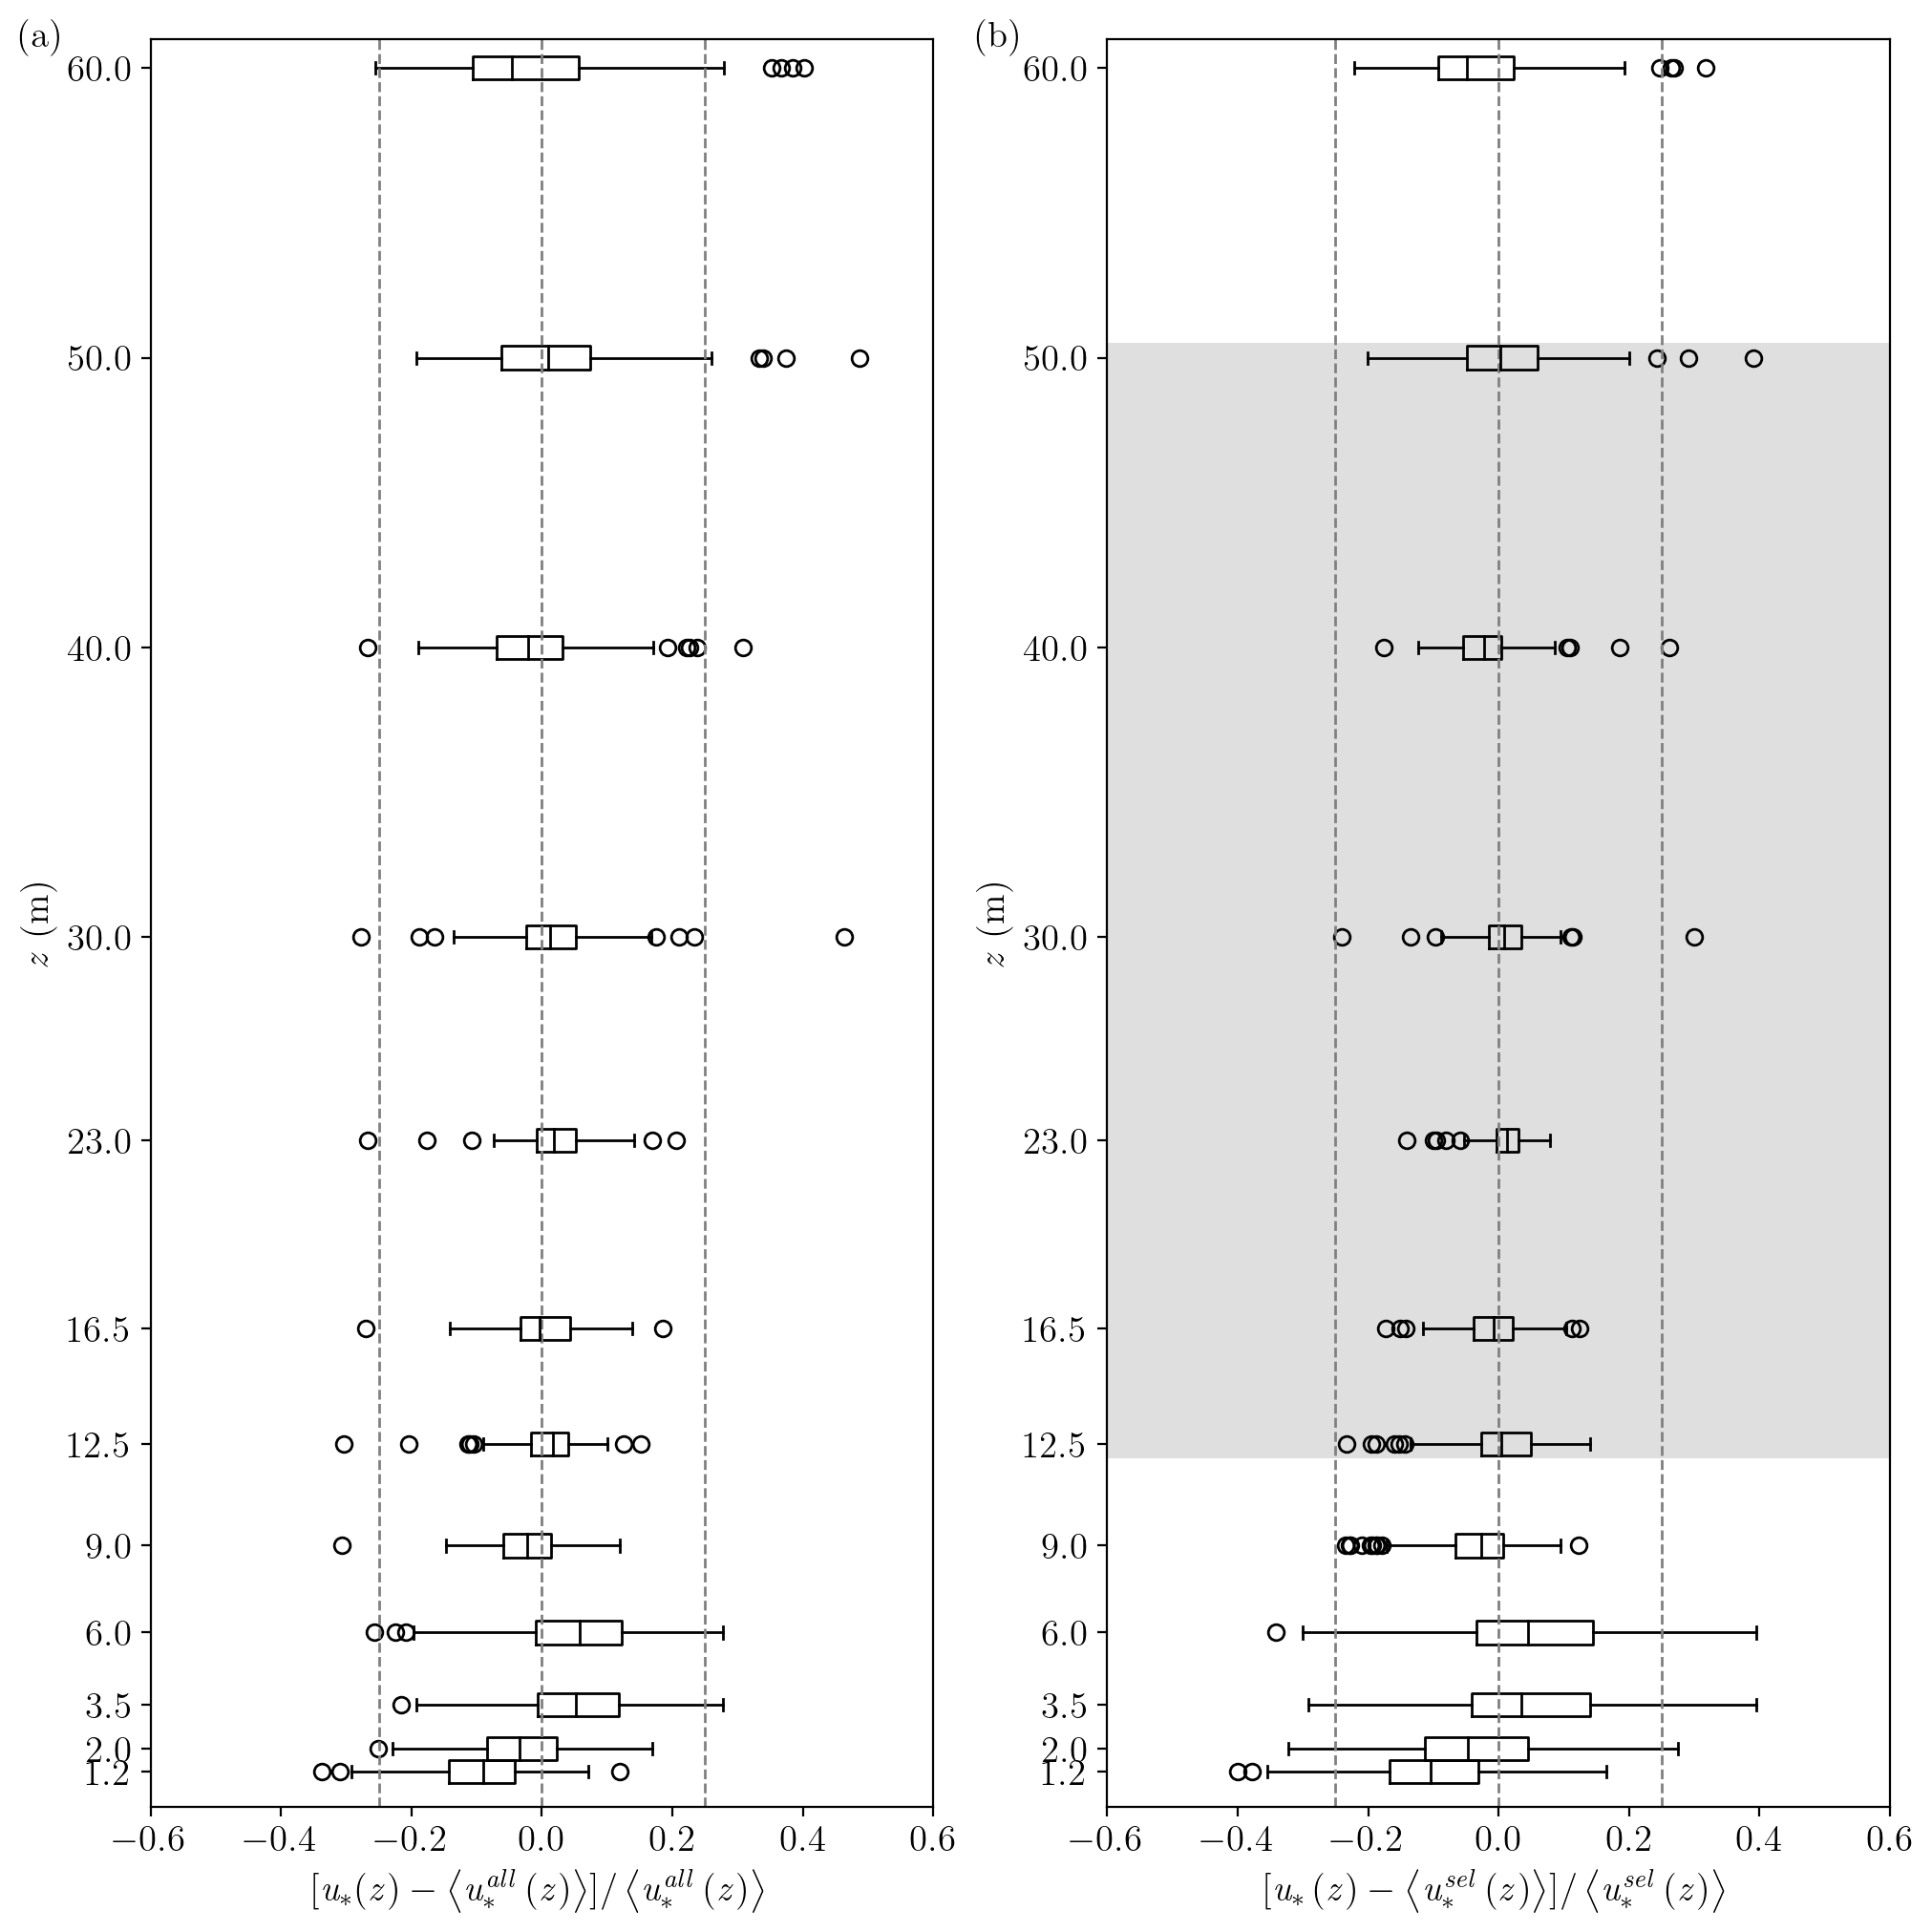

In [20]:
# fig = plt.figure(figsize=(6, 5), dpi=150,tight_layout=True)
text_loc = [-0.1, 0.98]
fig, axes = plt.subplot_mosaic([['a','b']], constrained_layout=True)
fig.set_size_inches(10, 10)
fig.set_dpi(200)
font_size = 12
# label physical distance in and down:
trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
medianprops = dict(linestyle='-', linewidth=1, color='k')
sample = var2d['all_level']['ldtr']['u_star_dev'][mask1]
mask = ~np.isnan(sample) # Filter data using np.isnan
filtered_data = [d[m] for d, m in zip(sample.T, mask.T)]
# filtered_data = np.array(filtered_data)
axes['a'].boxplot(filtered_data[:12], positions=z, vert=False, widths=0.8,
                medianprops=medianprops)
# axes['a'].boxplot(filtered_data[[0,1,2,3,4,5,6,7,8,9,10,11]],positions=z, vert=False, widths=0.8,
#                  medianprops=medianprops)
axes['a'].set_xlim(-0.6,0.6)
axes['a'].set_ylim(0,61)
# plot reference lines
axes['a'].axvline(x=0, color='grey', linestyle='--', linewidth=1)
axes['a'].axvline(x=0.25, color='grey', linestyle='--', linewidth=1)
axes['a'].axvline(x=-0.25, color='grey', linestyle='--', linewidth=1)
# axes['a'].axhspan(12, 50.5, facecolor='grey', alpha=0.25)

axes['a'].set_yticks(z)
axes['a'].tick_params(axis='y', labelsize=font_size+2)
axes['a'].tick_params(axis='x', labelsize=font_size+2)
axes['a'].set_ylabel(r'$\it z$ (m)', fontsize=font_size+2)
axes['a'].set_xlabel(r'$\it [u_*(z)-\left<u^{all}_*\left(z\right)\right>]/\left<u^{all}_*\left(z\right)\right>$', 
                     fontsize=font_size+2, weight='bold')
axes['a'].text(text_loc[0], text_loc[1], '(a)', transform=axes['a'].transAxes + trans,
                fontsize=font_size+2, va='bottom')

sample_sel = var2d['sel_level']['ldtr']['u_star_dev'][mask1]
mask_sel = ~np.isnan(sample_sel)
filtered_data_sel = [d[m] for d, m in zip(sample_sel.T, mask_sel.T)]
# filtered_data = np.array(filtered_data)
axes['b'].boxplot(filtered_data_sel[:12], positions=z, vert=False, widths=0.8,
                medianprops=medianprops)
axes['b'].set_xlim(-0.6,0.6)
axes['b'].set_ylim(0,61)
# plot reference lines
axes['b'].axvline(x=0, color='grey', linestyle='--', linewidth=1)
axes['b'].axvline(x=0.25, color='grey', linestyle='--', linewidth=1)
axes['b'].axvline(x=-0.25, color='grey', linestyle='--', linewidth=1)
axes['b'].axhspan(12, 50.5, facecolor='grey', alpha=0.25)

axes['b'].set_yticks(z)
axes['b'].tick_params(axis='y', labelsize=font_size+2)
axes['b'].tick_params(axis='x', labelsize=font_size+2)
axes['b'].set_ylabel(r'$\it z$ (m)', fontsize=font_size+2)
axes['b'].set_xlabel(r'$\it [u_*\left(z\right)-\left<u^{sel}_*\left(z\right)\right>]/\left<u^{sel}_*\left(z\right)\right>$', 
                     fontsize=font_size+2, weight='bold')
axes['b'].text(text_loc[0], text_loc[1], '(b)', transform=axes['b'].transAxes + trans,
                fontsize=font_size+2, va='bottom')
plt.savefig(OUT_PLOT_DIR + 'profile_u_star_ldtr_12l_6l.jpg', dpi=200)

In [26]:
filtered_data[0].shape

(122,)

## high pass filtered

Text(-0.05, 1, '(b)')

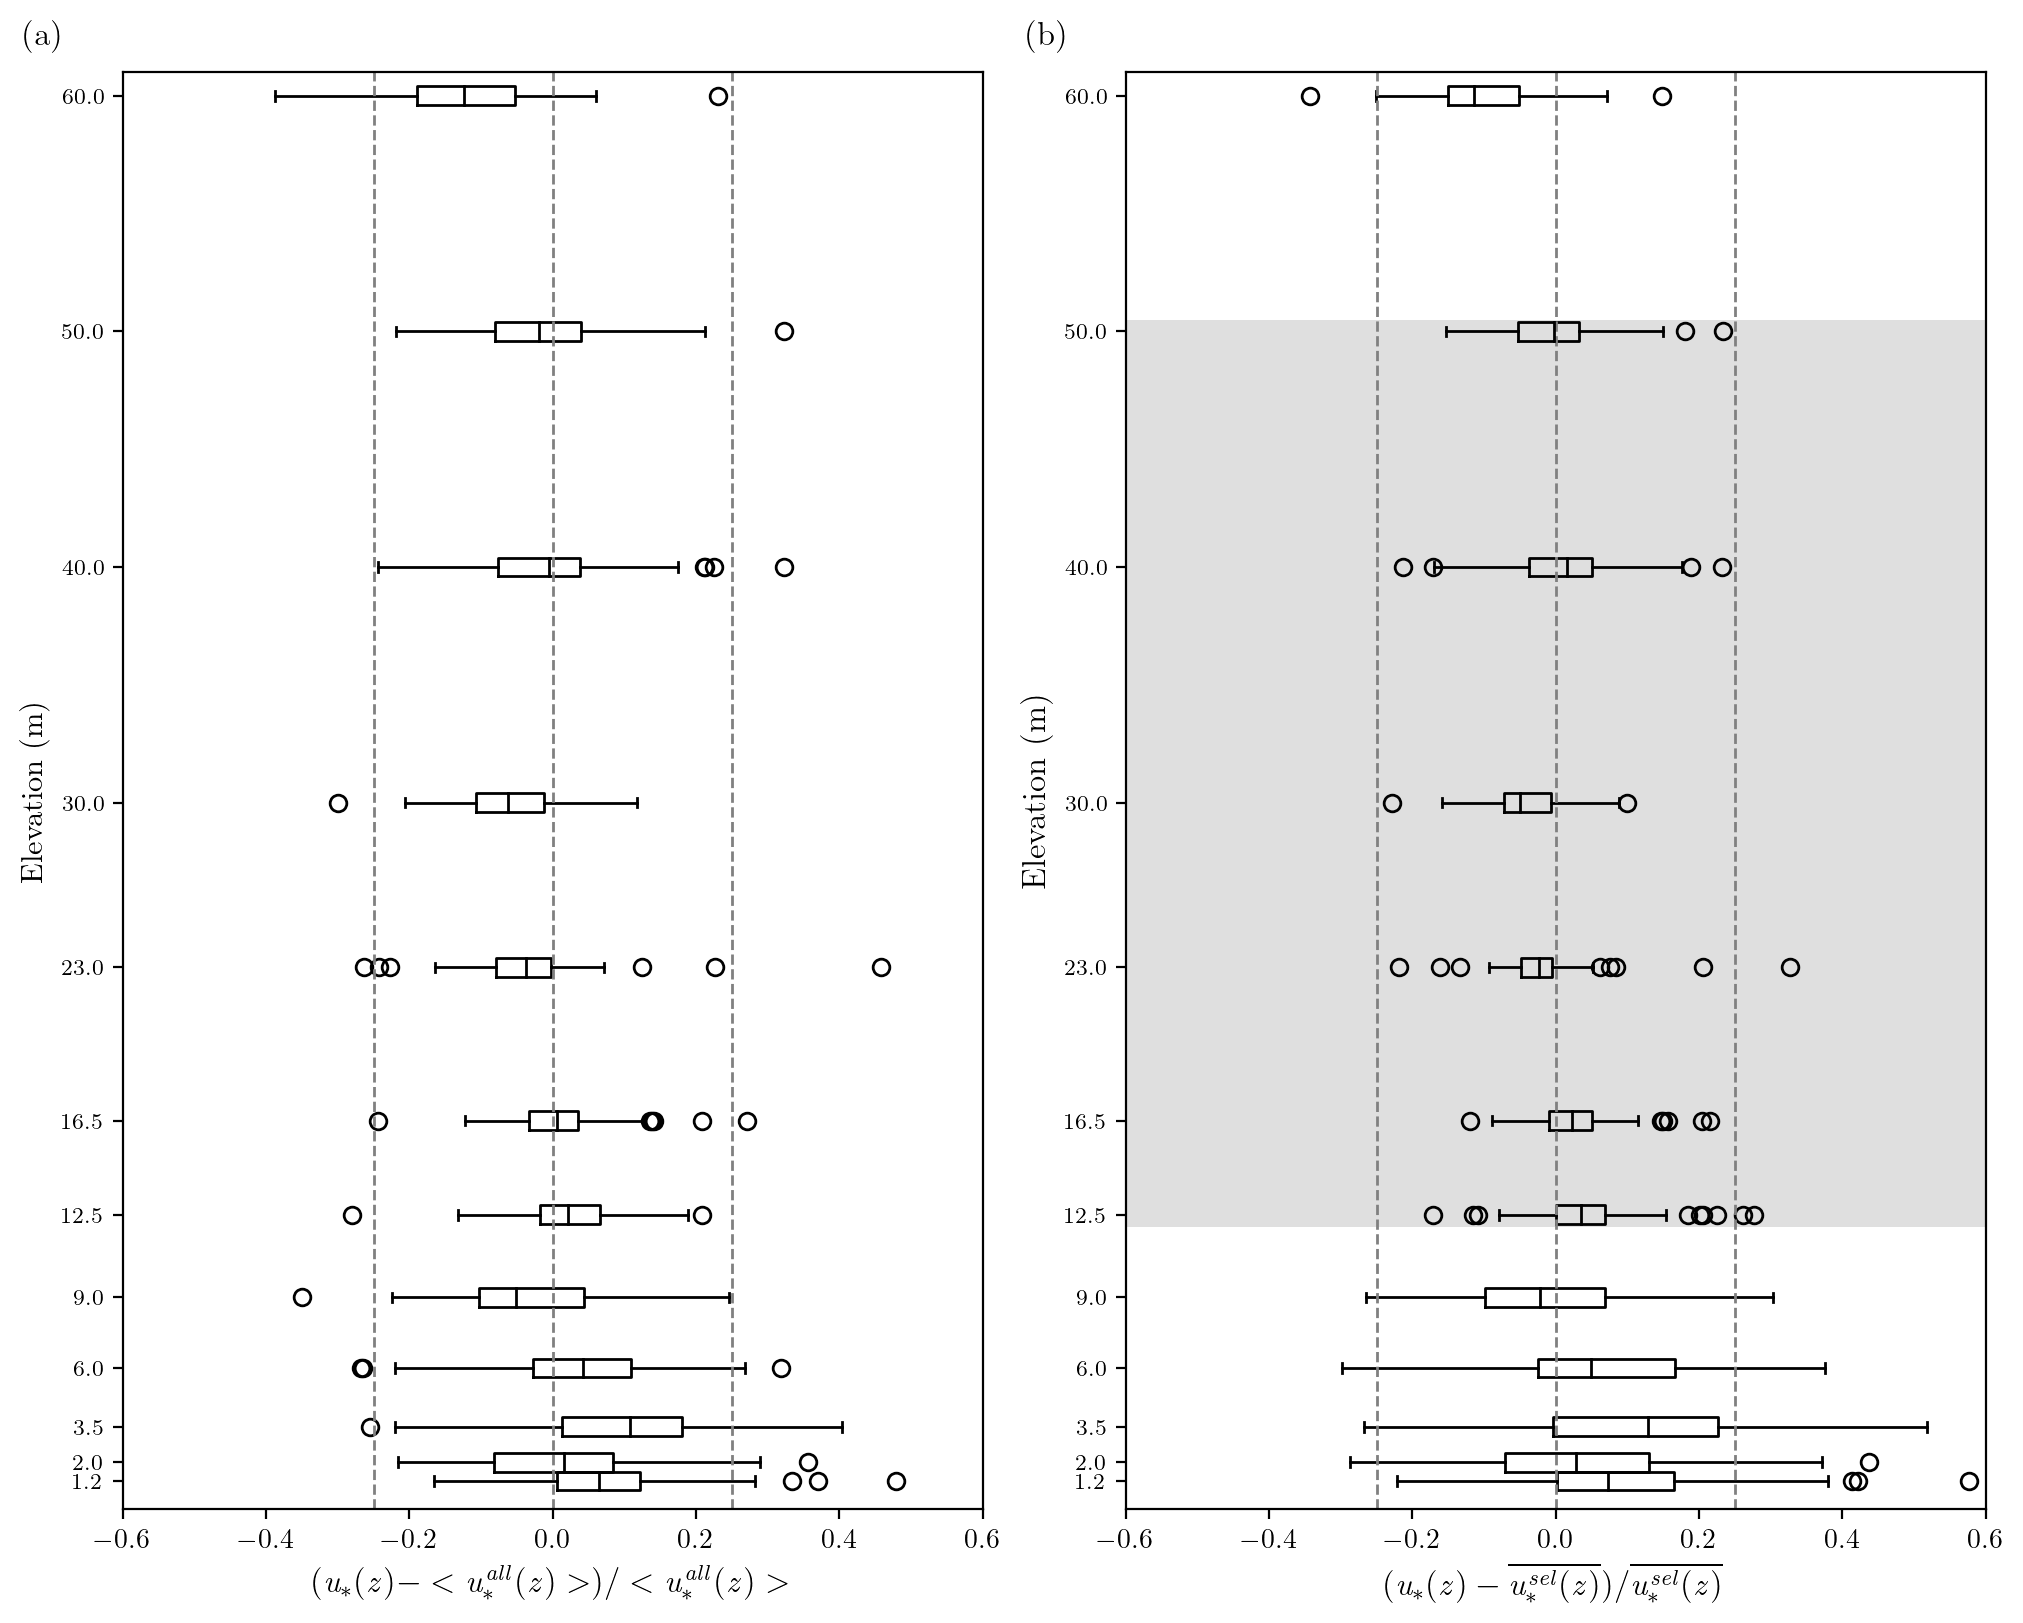

In [78]:
# fig = plt.figure(figsize=(6, 5), dpi=150,tight_layout=True)
fig, axes = plt.subplot_mosaic([['a','b']], constrained_layout=True)
fig.set_size_inches(10, 8)
fig.set_dpi(200)
# label physical distance in and down:
trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
medianprops = dict(linestyle='-', linewidth=1, color='k')
sample = var2d['all_level']['filt']['u_star_dev'][mask1]
mask = ~np.isnan(sample) # Filter data using np.isnan
filtered_data = [d[m] for d, m in zip(sample.T, mask.T)]
# filtered_data = np.array(filtered_data)
axes['a'].boxplot(filtered_data[:12],positions=z, vert=False, widths=0.8,
                 medianprops=medianprops)
axes['a'].set_xlim(-0.6,0.6)
axes['a'].set_ylim(0,61)
# plot reference lines
axes['a'].axvline(x=0, color='grey', linestyle='--', linewidth=1)
axes['a'].axvline(x=0.25, color='grey', linestyle='--', linewidth=1)
axes['a'].axvline(x=-0.25, color='grey', linestyle='--', linewidth=1)
# axes['a'].axhspan(12, 50.5, facecolor='grey', alpha=0.25)

axes['a'].set_yticks(z)
axes['a'].tick_params(axis='y', labelsize=8)
axes['a'].set_ylabel(r'\rm Elevation (m)', fontsize=font_size-1)
axes['a'].set_xlabel(r'$\it (u_*(z)-<u_*^{all}(z)>)/<u_*^{all}(z)>$', fontsize=font_size)
axes['a'].text(-0.05, 1, '(a)', transform=axes['a'].transAxes + trans,
                fontsize=font_size, va='bottom')

sample = var2d['sel_level']['filt']['u_star_dev'][mask1]
mask = ~np.isnan(sample) # Filter data using np.isnan
filtered_data = [d[m] for d, m in zip(sample.T, mask.T)]
# filtered_data = np.array(filtered_data)
axes['b'].boxplot(filtered_data[:12],positions=z, vert=False, widths=0.8,
                 medianprops=medianprops)
axes['b'].set_xlim(-0.6,0.6)
axes['b'].set_ylim(0,61)
# plot reference lines
axes['b'].axvline(x=0, color='grey', linestyle='--', linewidth=1)
axes['b'].axvline(x=0.25, color='grey', linestyle='--', linewidth=1)
axes['b'].axvline(x=-0.25, color='grey', linestyle='--', linewidth=1)
axes['b'].axhspan(12, 50.5, facecolor='grey', alpha=0.25)

axes['b'].set_yticks(z)
axes['b'].tick_params(axis='y', labelsize=8)
axes['b'].set_ylabel(r'\rm Elevation (m)', fontsize=font_size)
axes['b'].set_xlabel(r'$\it (u_*(z)-\overline{u_*^{sel}(z)})/\overline{u_*^{sel}(z)}$', fontsize=font_size)
axes['b'].text(-0.05, 1, '(b)', transform=axes['b'].transAxes + trans,
                fontsize=font_size, va='bottom')
# plt.savefig(FIG_DIR + 'profile_u_star_ldtr_12l_6l.jpg', dpi=200)

# Plot PDF of fitted kappa

In [21]:
font_size

12

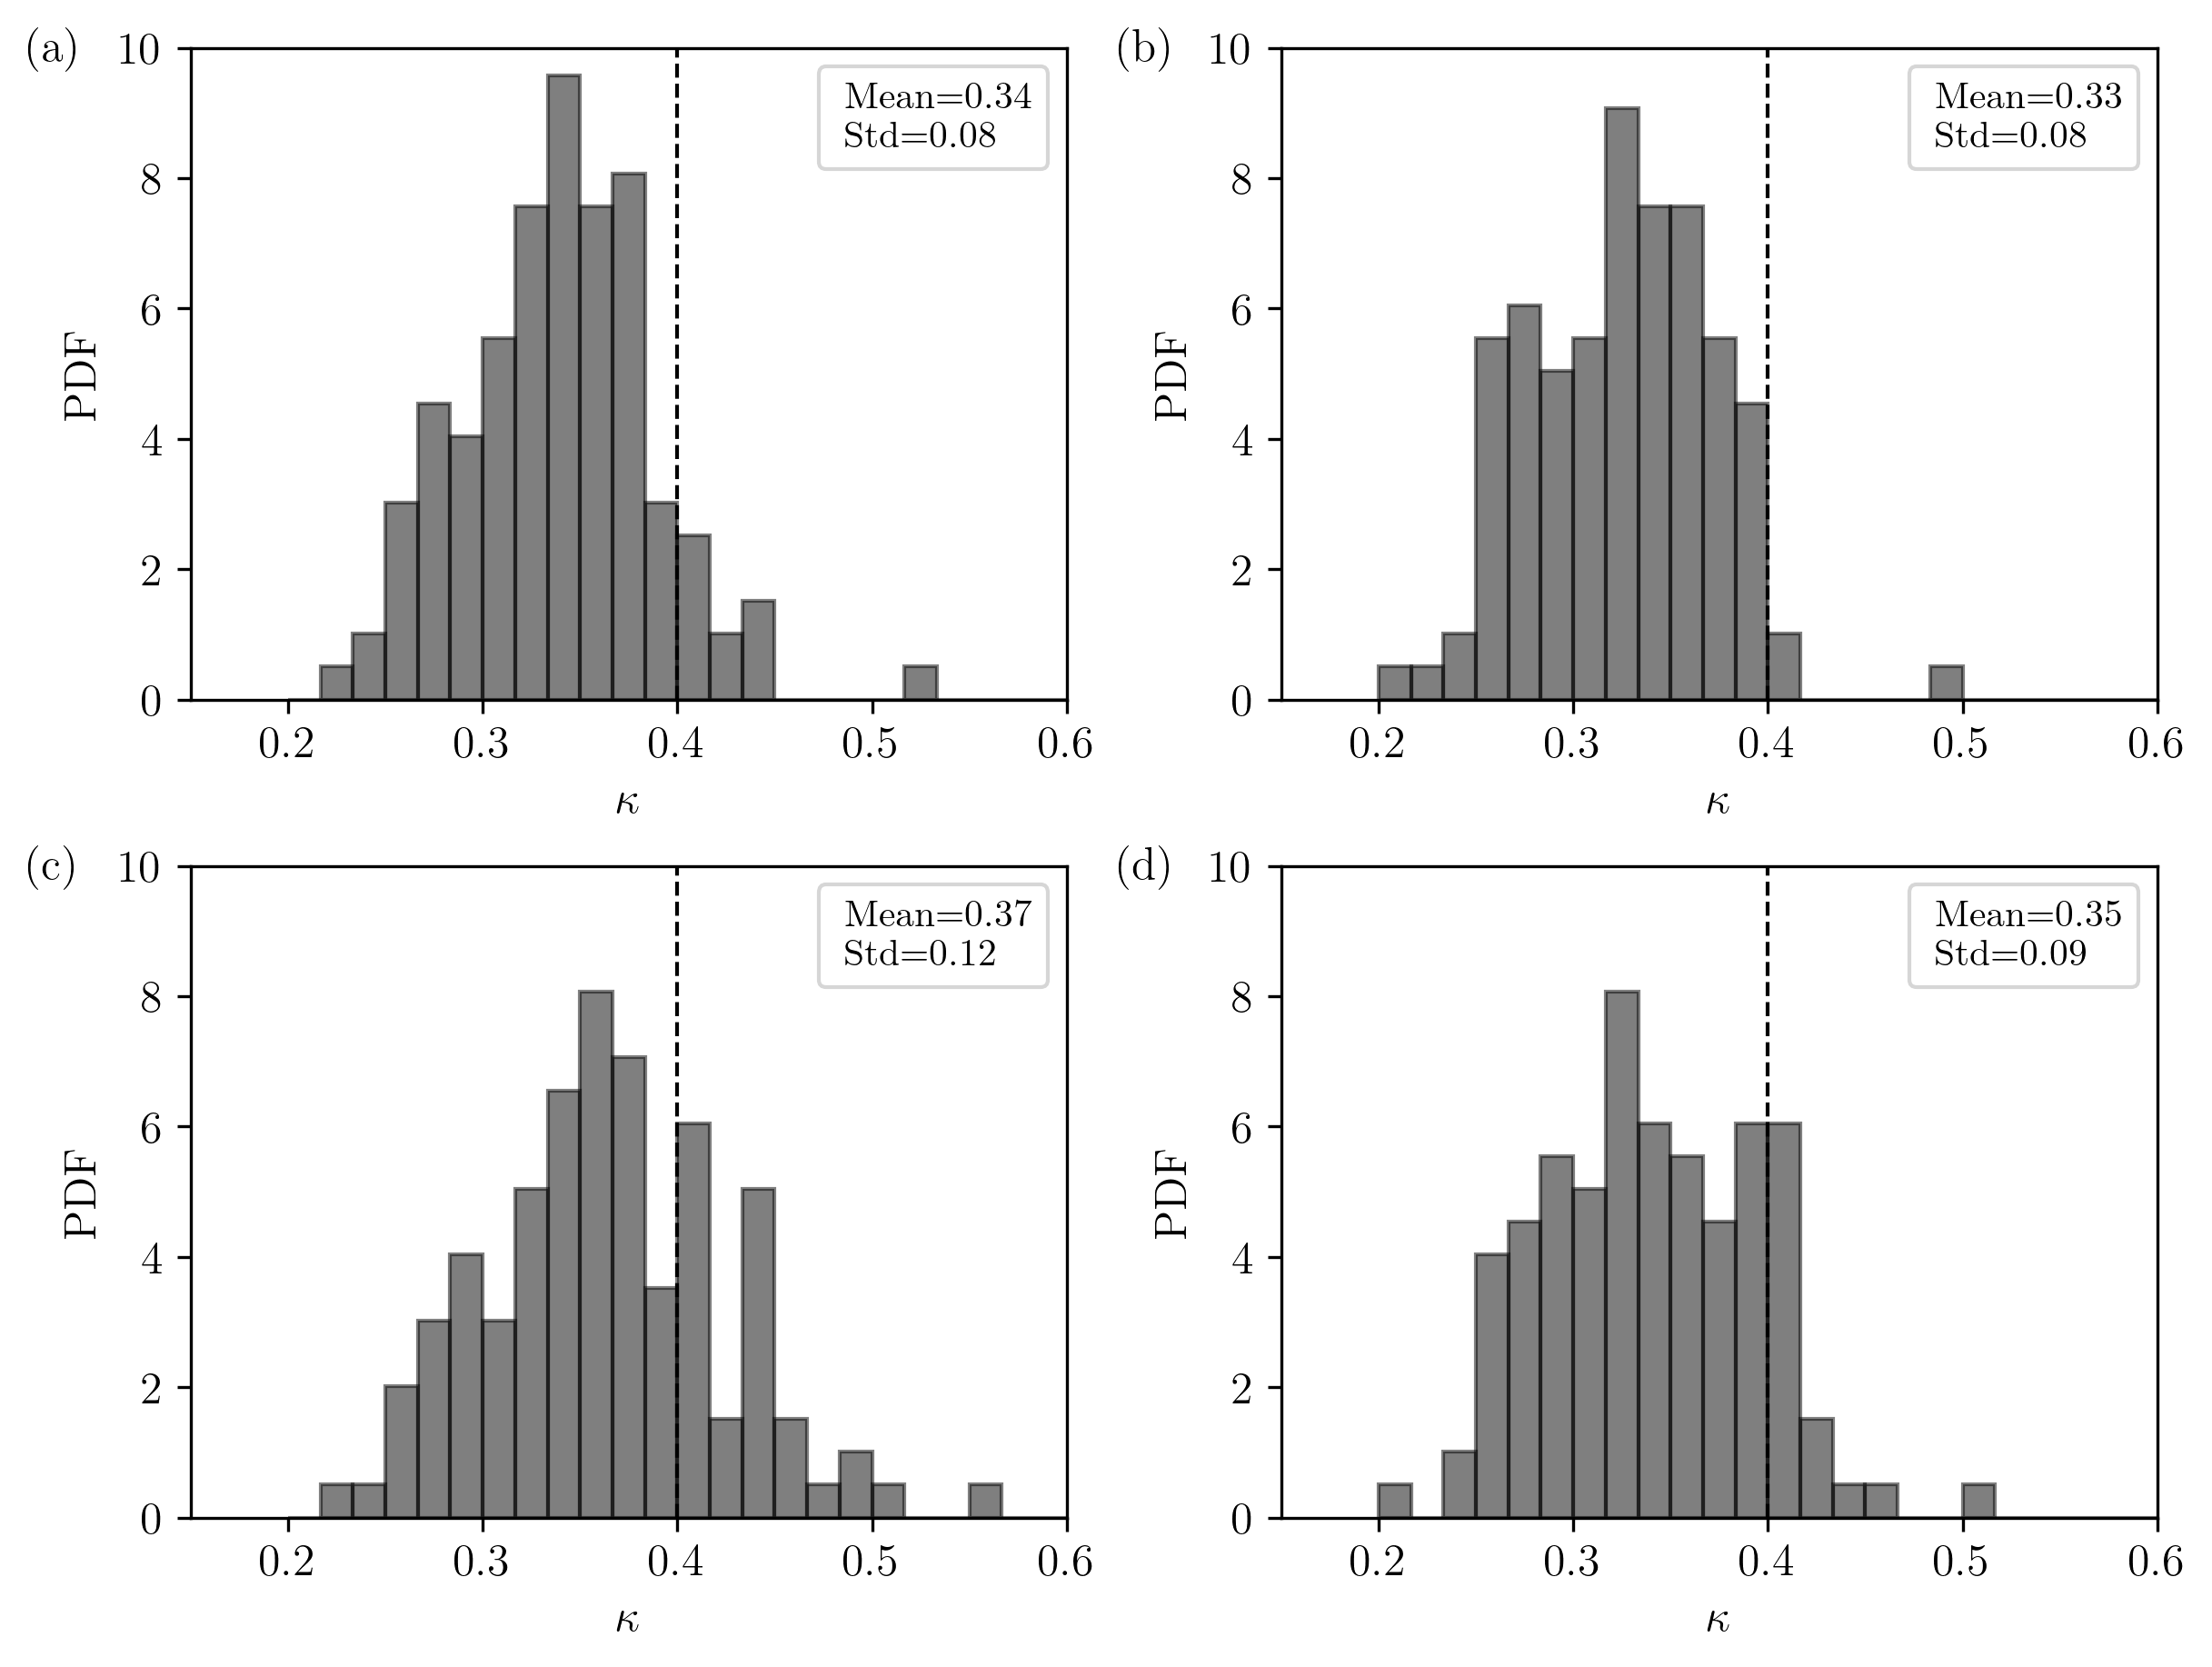

In [25]:
from matplotlib.lines import Line2D
fig, axes = plt.subplot_mosaic([['a','b'],['c','d']], constrained_layout=True)
fig.set_size_inches(8,6)
fig.set_dpi(300)
text_loc = [-0.1, 0.94]
font_size = 12
# label physical distance in and down:
trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
# Create a custom legend
custom_lines = [Line2D([0], [0], color="none", marker='o', markerfacecolor="none")]

def plot_kappa_pdf(fig_lbl,ax_,level):
    data = var1d[level]['filt']['kappa_fit'][mask1]
    # label='Mean={:.2f}\nStd={:.2f}'.format(np.nanmean(data), np.nanstd(data))
    sns.distplot(data, hist=True, kde=True,
                 bins=24, color = 'black', 
                 hist_kws={'edgecolor':'black',"range": [0.2,0.6],'alpha':0.5},
                 kde_kws={'linewidth': 0},
                 ax=ax_)
    # ax_.annotate(label, xy=(0.7,0.8),xycoords='axes fraction',
    #              fontsize=font_size-2, 
    #              bbox={'facecolor': 'white', 'edgecolor': 'gray', 'pad': 1, 'boxstyle': 'round,pad=0.3'})
    label = [r'Mean={:.2f}'.format(np.nanmean(data))
            +'\n'+
            r'Std={:.2f}'.format(np.nanstd(data))
           ]
    legend= ax_.legend(custom_lines, label,fontsize=font_size-2, handlelength=-0.5)
    # legend.get_frame().set_linewidth(line_width)
    ax_.set_xlim(0.15,0.6)
    ax_.set_ylim(0,10)
    ax_.set_xlabel(r'$\kappa$', fontsize = font_size)
    ax_.set_ylabel(r'PDF', fontsize = font_size)
    ax_.tick_params(axis='both', labelsize=font_size)
    ax_.axvline(x=0.4, color='k', linestyle='--', linewidth=1)
    ax_.text(text_loc[0], text_loc[1], fig_lbl, transform=ax_.transAxes + trans,
            fontsize=font_size, zorder=2, 
            bbox={'facecolor': 'white', 'edgecolor': 'none', 'pad': 1})

plot_kappa_pdf('(a)',axes['a'],'test2')
# axes['a'].set_title('5th to 11th')
    
plot_kappa_pdf('(b)',axes['b'],'test1')
# axes['b'].set_title('5th to 12th')

plot_kappa_pdf('(c)',axes['c'],'sel_level')
# axes['c'].set_title('6th to 11th')

plot_kappa_pdf('(d)',axes['d'],'test3')
# axes['d'].set_title('6th to 12th')

plt.savefig(OUT_PLOT_DIR+'PDF_kappa_test.jpg', dpi=300)

## Plot PDF of R^2

(0.0, 50.0)

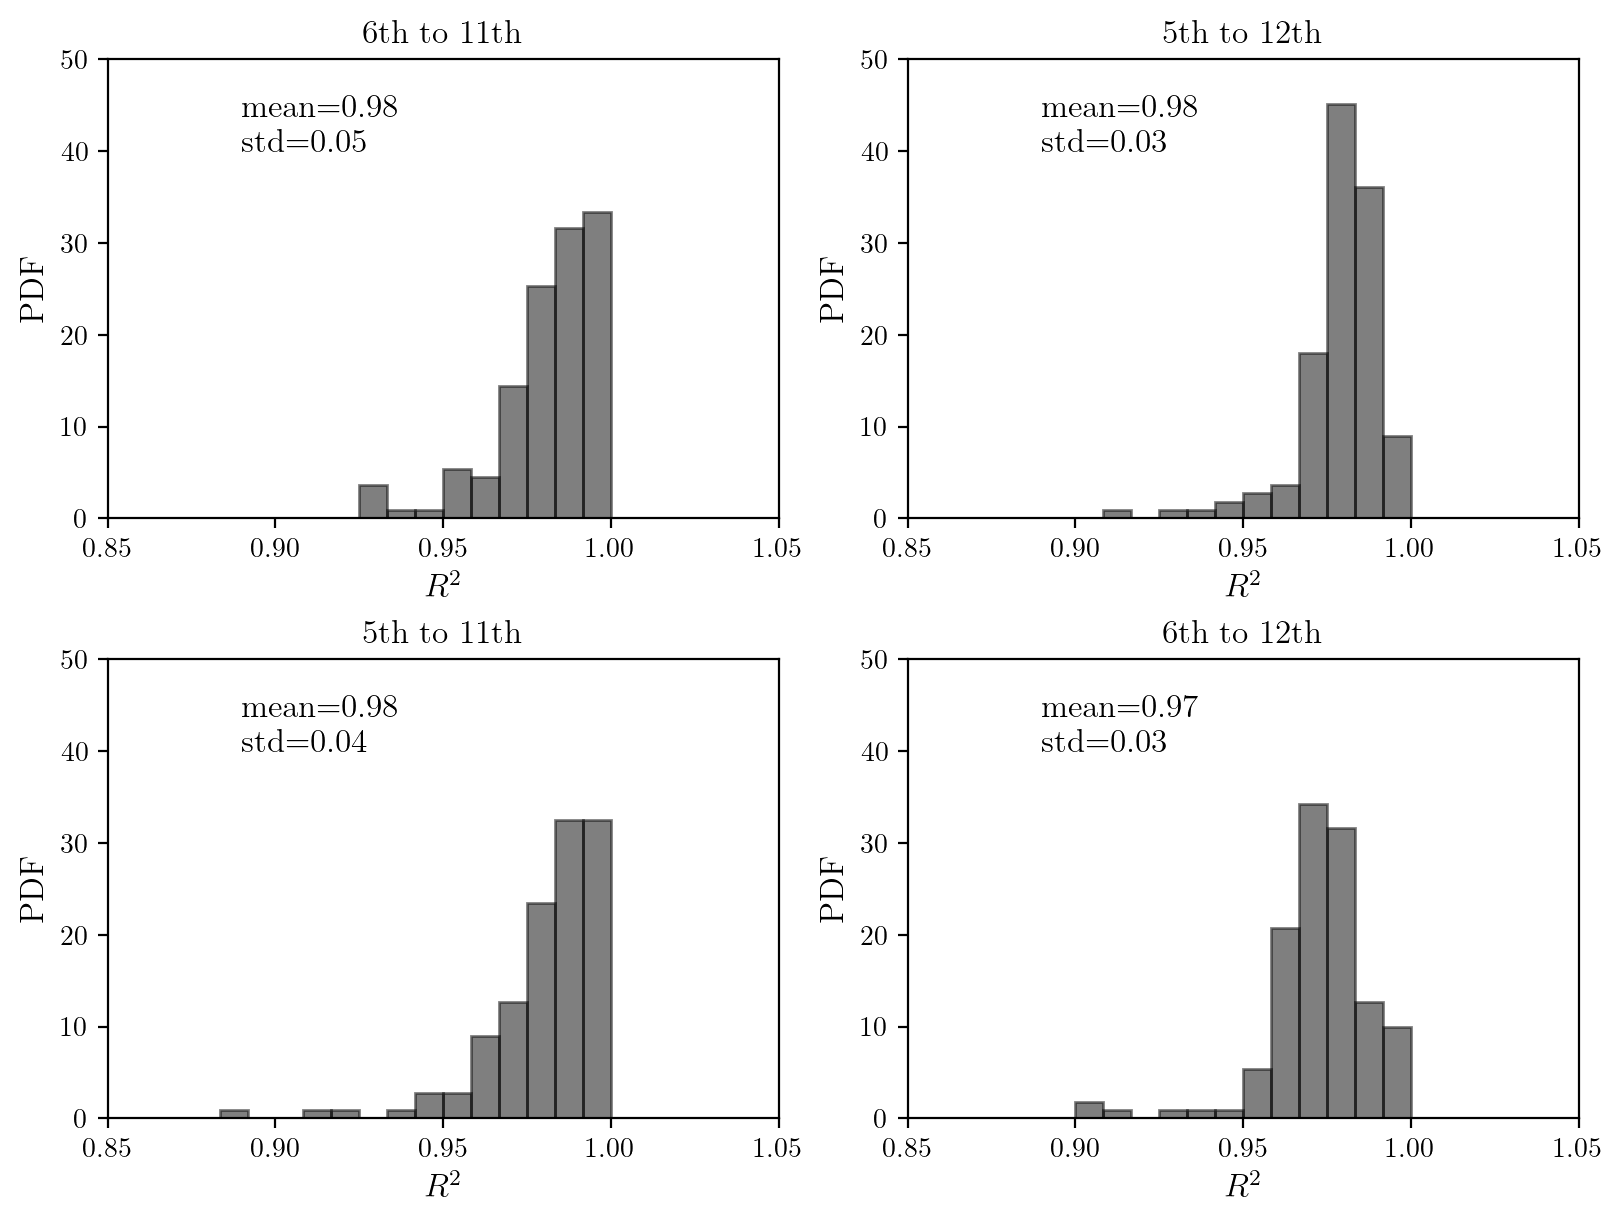

In [82]:
fig, axes = plt.subplot_mosaic([['a','b'],['c','d']], constrained_layout=True)
fig.set_size_inches(8,6)
fig.set_dpi(200)
mask = mask_rnan*mask_dspk*mask_neutral*mask_wdir*mask_taylor*mask_ustar_gt005

# sample = r2_ldtr_sel[mask]
sample = var1d['sel_level']['filt']['r2_uavg'][mask]
label='mean={:.2f}\nstd={:.2f}'.format(np.nanmean(sample), np.nanstd(sample))
sns.distplot(sample, hist=True, kde=True,
             bins=24, color = 'black', 
             hist_kws={'edgecolor':'black',"range": [0.8,1],'alpha':0.5},
             kde_kws={'linewidth': 0},
             label = label,ax=axes['a'])
axes['a'].annotate(label, xy=(0.2,0.8),xycoords='axes fraction', fontsize=font_size)
axes['a'].set_xlabel(r'$R^2$', fontsize = font_size)
axes['a'].set_ylabel(r'PDF', fontsize = font_size)
axes['a'].set_title('6th to 11th')
axes['a'].set_xlim(0.85,1.05)
axes['a'].set_ylim(0,50)

# sample = r2_ldtr_test1[mask]
sample = var1d['test1']['filt']['r2_uavg'][mask]
label='mean={:.2f}\nstd={:.2f}'.format(np.nanmean(sample), np.nanstd(sample))
sns.distplot(sample, hist=True, kde=True,
             bins=24, color = 'black', 
             hist_kws={'edgecolor':'black',"range": [0.8,1],'alpha':0.5},
             kde_kws={'linewidth': 0},
             label = label,ax=axes['b'])
axes['b'].annotate(label, xy=(0.2,0.8),xycoords='axes fraction', fontsize=font_size)
axes['b'].set_xlabel(r'$R^2$', fontsize = font_size)
axes['b'].set_ylabel(r'PDF', fontsize = font_size)
axes['b'].set_title('5th to 12th')
axes['b'].set_xlim(0.85,1.05)
axes['b'].set_ylim(0,50)

# sample = r2_ldtr_test2[mask]
sample = var1d['test2']['filt']['r2_uavg'][mask]
label='mean={:.2f}\nstd={:.2f}'.format(np.nanmean(sample), np.nanstd(sample))
sns.distplot(sample, hist=True, kde=True,
             bins=24, color = 'black', 
             hist_kws={'edgecolor':'black',"range": [0.8,1],'alpha':0.5},
             kde_kws={'linewidth': 0},
             label = label,ax=axes['c'])
axes['c'].annotate(label, xy=(0.2,0.8),xycoords='axes fraction', fontsize=font_size)
axes['c'].set_xlabel(r'$R^2$', fontsize = font_size)
axes['c'].set_ylabel(r'PDF', fontsize = font_size)
axes['c'].set_title('5th to 11th')
axes['c'].set_xlim(0.85,1.05)
axes['c'].set_ylim(0,50)

# sample = r2_ldtr_test3[mask]
sample = var1d['test3']['filt']['r2_uavg'][mask]
label='mean={:.2f}\nstd={:.2f}'.format(np.nanmean(sample), np.nanstd(sample))
sns.distplot(sample, hist=True, kde=True,
             bins=24, color = 'black', 
             hist_kws={'edgecolor':'black',"range": [0.8,1],'alpha':0.5},
             kde_kws={'linewidth': 0},
             label = label,ax=axes['d'])
axes['d'].annotate(label, xy=(0.2,0.8),xycoords='axes fraction', fontsize=font_size)
axes['d'].set_xlabel(r'$R^2$', fontsize = font_size)
axes['d'].set_ylabel(r'PDF', fontsize = font_size)
axes['d'].set_title('6th to 12th')
axes['d'].set_xlim(0.85,1.05)
axes['d'].set_ylim(0,50)

# plt.savefig(OUT_PLOT_DIR+'PDF_kappa_test.jpg', dpi=200)

## Plot u_star vertical deviation

Text(0.5, 0, '$\\it (u_*(z)-\\overline{u_*(z)})/\\overline{u_*(z)}$')

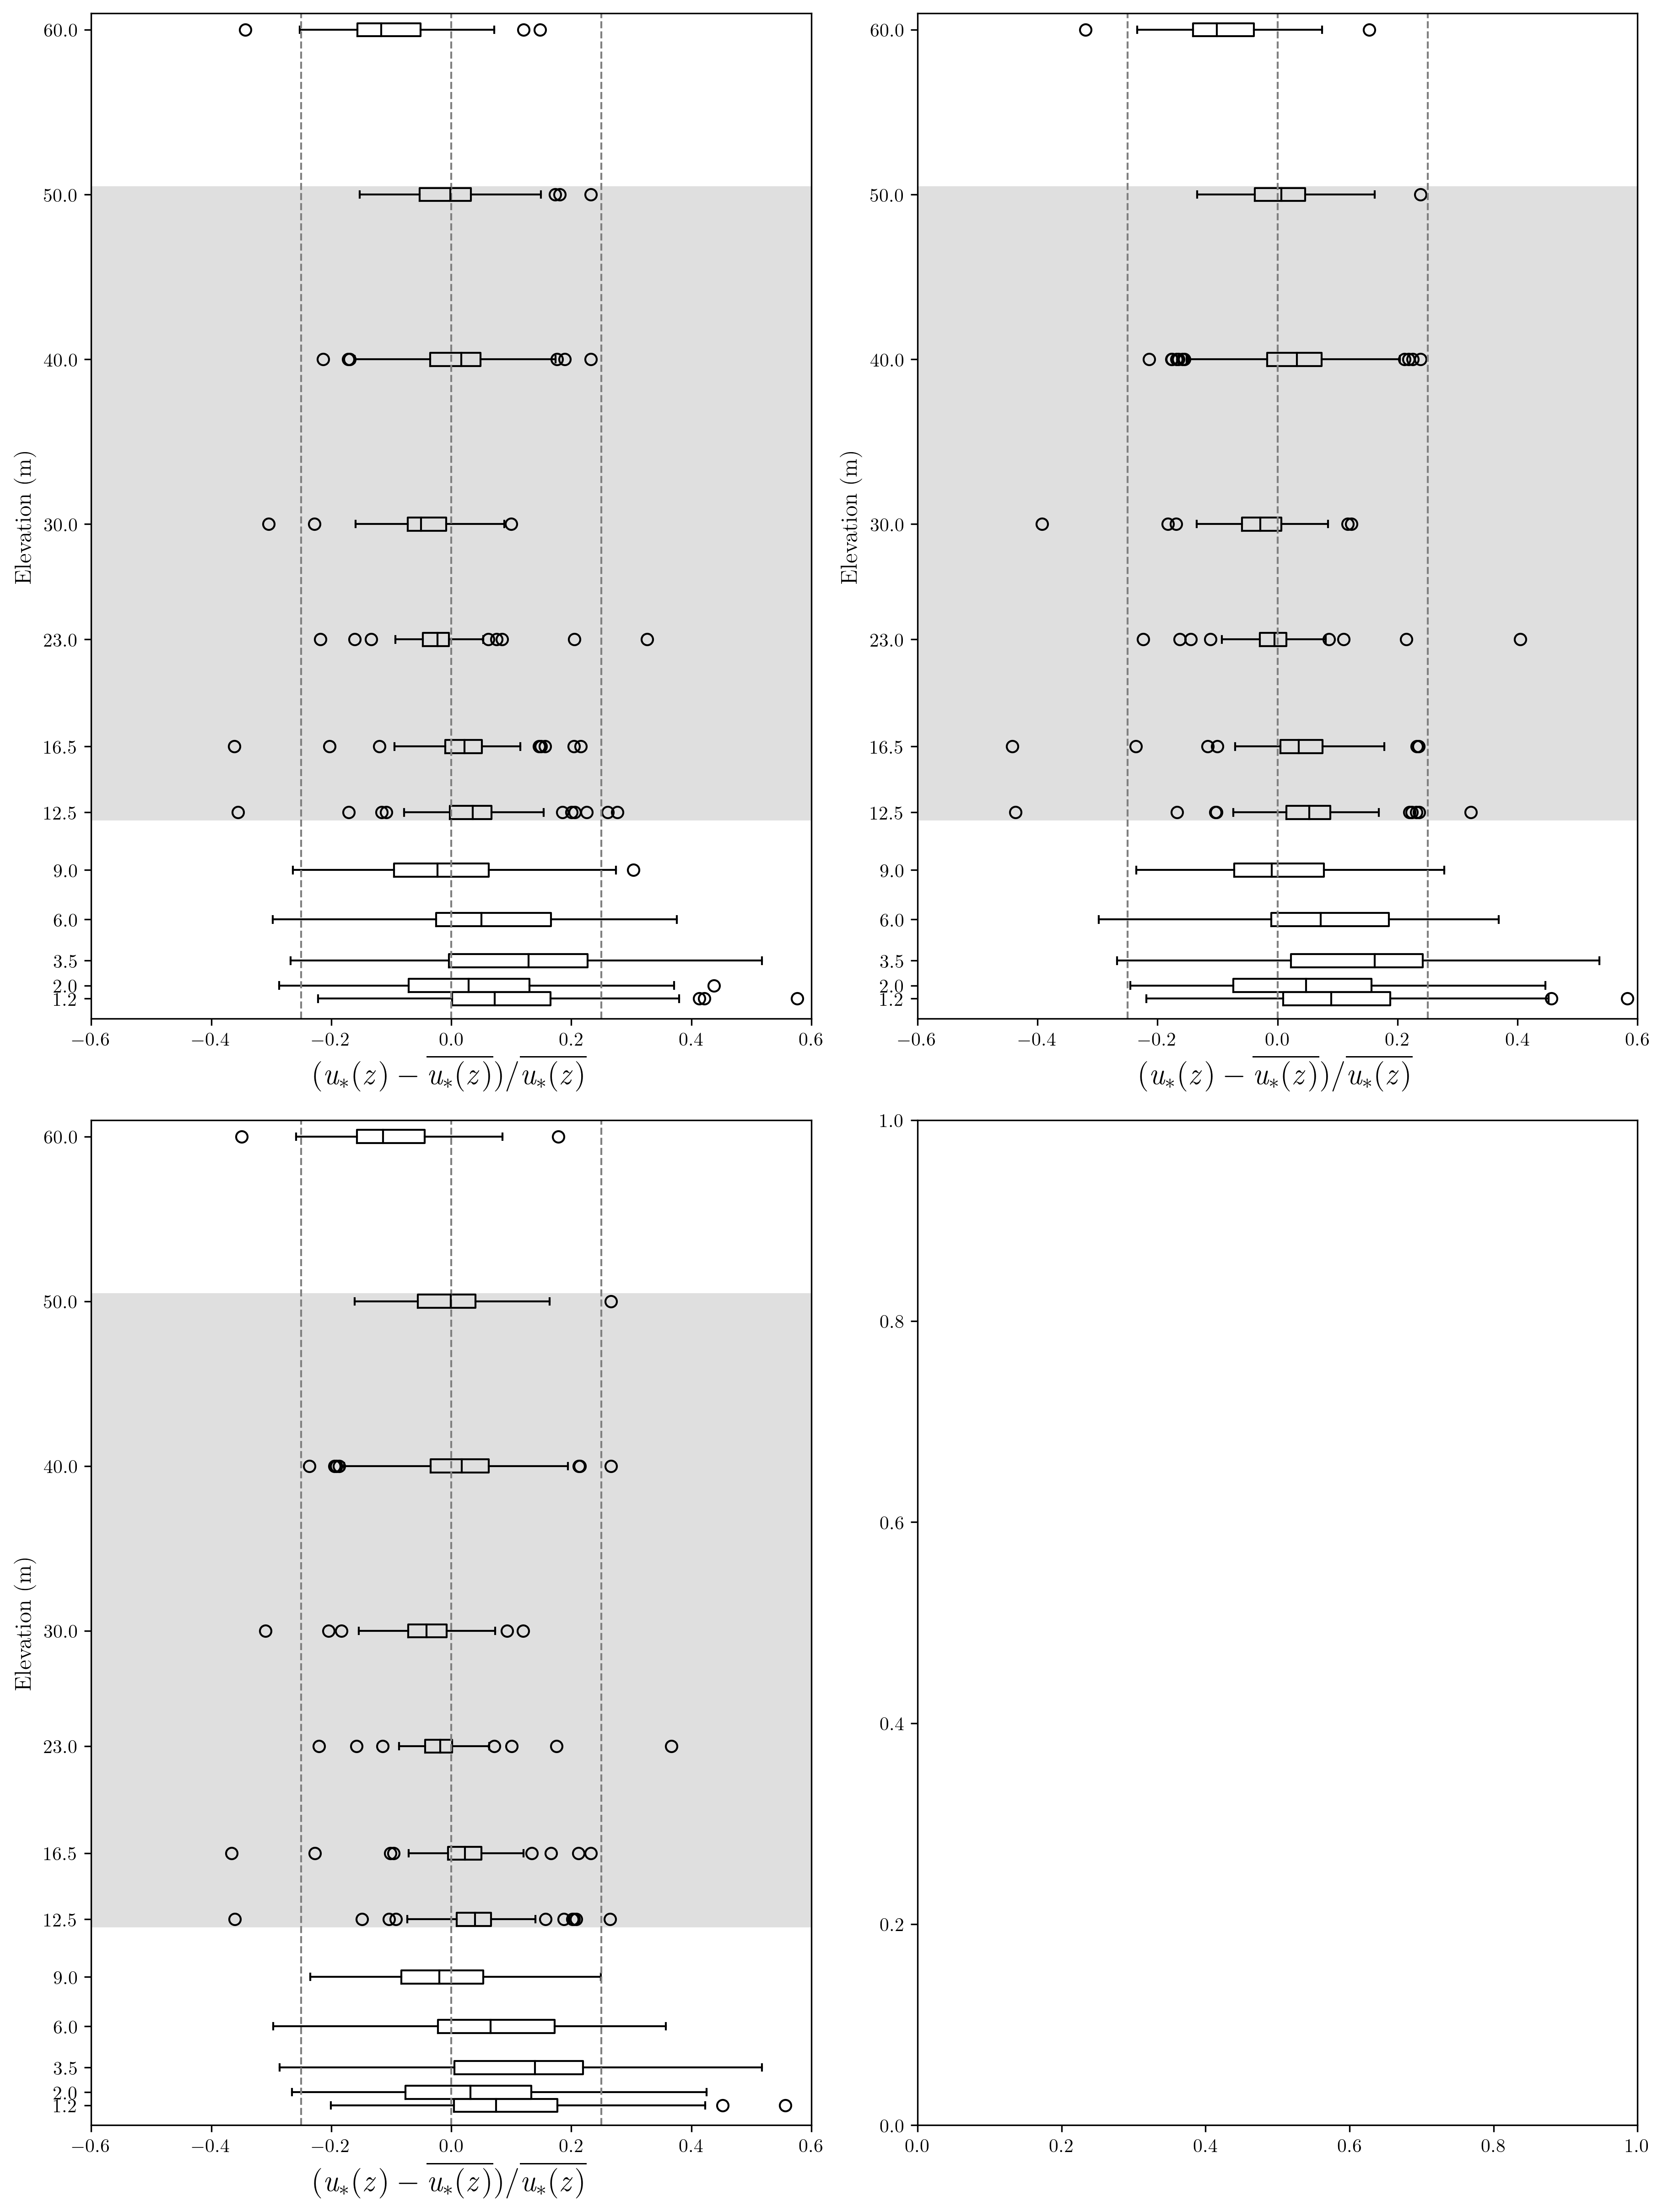

In [83]:
fig, axes = plt.subplot_mosaic([['a','b'],['c','d']], constrained_layout=True)
fig.set_size_inches(12, 16)
fig.set_dpi(300)
medianprops = dict(linestyle='-', linewidth=1, color='k')

# subplot a
sample = var2d['sel_level']['filt']['u_star_dev'][mask]
mask_ = ~np.isnan(sample) # Filter data using np.isnan
filtered_data = [d[m] for d, m in zip(sample.T, mask_.T)]
# filtered_data = np.array(filtered_data)
axes['a'].boxplot(filtered_data[:12],positions=z, vert=False, widths=0.8,
                 medianprops=medianprops)
axes['a'].set_xlim(-0.6,0.6)
axes['a'].set_ylim(0,61)
# plot reference lines
axes['a'].axvline(x=0, color='grey', linestyle='--', linewidth=1)
axes['a'].axvline(x=0.25, color='grey', linestyle='--', linewidth=1)
axes['a'].axvline(x=-0.25, color='grey', linestyle='--', linewidth=1)
axes['a'].axhspan(12, 50.5, facecolor='grey', alpha=0.25)

axes['a'].set_ylabel(r'Elevation (m)', fontsize=font_size)
axes['a'].set_xlabel(r'$\it (u_*(z)-\overline{u_*(z)})/\overline{u_*(z)}$', fontsize=font_size+4)

# subplot b
sample = var2d['test1']['filt']['u_star_dev'][mask]
mask_ = ~np.isnan(sample) # Filter data using np.isnan
filtered_data = [d[m] for d, m in zip(sample.T, mask_.T)]
# filtered_data = np.array(filtered_data)
axes['b'].boxplot(filtered_data[:12],positions=z, vert=False, widths=0.8,
                 medianprops=medianprops)
axes['b'].set_xlim(-0.6,0.6)
axes['b'].set_ylim(0,61)
# plot reference lines
axes['b'].axvline(x=0, color='grey', linestyle='--', linewidth=1)
axes['b'].axvline(x=0.25, color='grey', linestyle='--', linewidth=1)
axes['b'].axvline(x=-0.25, color='grey', linestyle='--', linewidth=1)
axes['b'].axhspan(12, 50.5, facecolor='grey', alpha=0.25)

axes['b'].set_ylabel(r'Elevation (m)', fontsize=font_size)
axes['b'].set_xlabel(r'$\it (u_*(z)-\overline{u_*(z)})/\overline{u_*(z)}$', fontsize=font_size+4)

# subplot c
sample = var2d['test2']['filt']['u_star_dev'][mask]
mask_ = ~np.isnan(sample) # Filter data using np.isnan
filtered_data = [d[m] for d, m in zip(sample.T, mask_.T)]
# filtered_data = np.array(filtered_data)
axes['c'].boxplot(filtered_data[:12],positions=z, vert=False, widths=0.8,
                 medianprops=medianprops)
axes['c'].set_xlim(-0.6,0.6)
axes['c'].set_ylim(0,61)
# plot reference lines
axes['c'].axvline(x=0, color='grey', linestyle='--', linewidth=1)
axes['c'].axvline(x=0.25, color='grey', linestyle='--', linewidth=1)
axes['c'].axvline(x=-0.25, color='grey', linestyle='--', linewidth=1)
axes['c'].axhspan(12, 50.5, facecolor='grey', alpha=0.25)

axes['c'].set_ylabel(r'Elevation (m)', fontsize=font_size)
axes['c'].set_xlabel(r'$\it (u_*(z)-\overline{u_*(z)})/\overline{u_*(z)}$', fontsize=font_size+4)

# *** Do fitting with ISL being decided (6th to 11th level)

In [84]:
# Define variable names
var1d_names = ['stability_parameter', 'kappa_corrected', 'A1_fit', 
               'slope_ustd', 'intercept_ustd', 'r2_ustd', 'slope_wstd_ustar','r2_wstd']
var2d_names = ['wind_ang_convert','Re_plus', 'IST_u', 'IST_wdir','score_wstd']

# Initialize all variables using nested dictionary comprehensions
varISL_1d = {type_: {name: np.zeros(n_hours) * np.nan for name in var1d_names} 
               for type_ in var_types}
varISL_2d = {type_: {name: np.zeros((n_hours,sonum)) * np.nan for name in var2d_names} 
               for type_ in var_types}
# score_shear only has (sonum-1) columns
varISL_2d['ldtr']['score_shear_wdir'] = np.zeros((n_hours,sonum-1)) * np.nan
varISL_2d['ldtr']['score_shear_wspd'] = np.zeros((n_hours,sonum-1)) * np.nan
varISL_2d['filt']['score_shear_wdir'] = np.zeros((n_hours,sonum-1)) * np.nan
varISL_2d['filt']['score_shear_wspd'] = np.zeros((n_hours,sonum-1)) * np.nan

In [85]:
varISL_2d['ldtr'].keys()

dict_keys(['wind_ang_convert', 'Re_plus', 'IST_u', 'IST_wdir', 'score_wstd', 'score_shear_wdir', 'score_shear_wspd'])

In [86]:
var1d['sel_level']['ldtr']['u_star_mean']

array([0.5375753 , 0.30164456, 0.25346491, ...,        nan,        nan,
              nan])

In [87]:
%%time
for i in range(n_hours):
    if mask_rnan[i]: # skip nan hours (mask_rnan=0)
        print(datetime_all[i])
        for type_ in var_types:
            # Calculate stability parameter with <z>
            varISL_1d[type_]['stability_parameter'][i] = gmean(z[list_sel])/ndimage.median(globals()[f'L_H2_{type_}'][i,list_sel])
            
            # 1. Calculate stability corrected kappa
            cal_stability_corrected_kappa(type_, i)
            
            # Convert wind angle to [-180,180]
            varISL_2d[type_]['wind_ang_convert'][i,:] = convert_ang(wind_ang_all[i,:],1)
            
            # 2. Fit A1 using the selected levels ------------------------------------------------------
            cal_ustd_fits(type_, i)
            
            # 3. Calculate Re_plus
            varISL_2d[type_]['Re_plus'][i,:] = z*var1d['sel_level'][type_]['u_star_mean'][i]/nu
            
            # 4. Calculate IST
            # Load turbulent data
            strday = str(datetime_all[i][0].strftime("%Y%m%d"))
            ih = datetime_all[i][1]
            for var_name in in_tur:
                globals()[var_name] = np.load(f"{IN_INS_DIR}{var_name}_{strday}_{ih:02}00.npy")
                
            for il in range(sonum): # loop over levels
                ## IST(wspd)
                varISL_2d[type_]['IST_u'][i,il] = ist_wspd_5min(globals()[f'u_dspk_2rot_{type_}'][:,il])
                ## IST(wdir)
                varISL_2d[type_]['IST_wdir'][i,il] = ist_wdir(ux_dspk[:,il],uy_dspk[:,il],varISL_2d[type_]['wind_ang_convert'][i,il])
            mean_w_std = np.nanmean(globals()[f'w_std_{type_}'][i,list_sel])
            varISL_2d[type_]['score_wstd'][i,:] = abs(globals()[f'w_std_{type_}'][i,:]-mean_w_std)/mean_w_std
            varISL_2d[type_]['score_shear_wdir'][i,:] = np.diff(varISL_2d[type_]['wind_ang_convert'][i,:])/np.diff(z)
            varISL_2d[type_]['score_shear_wspd'][i,:] = np.diff(globals()[f'u_avg_{type_}'][i,:])/np.diff(z)

            # 5. Fit w_std against u_star
            cal_wstd_fits_through_origin(type_, i)

[datetime.date(2020, 9, 25) 0]
Slope: 0.4404589522478777, R-squared: 0.8999909762802932
Slope: 1.0686424370705916, R-squared: 0.875922404494886
[datetime.date(2020, 9, 25) 1]
Slope: 0.917822064699579, R-squared: 0.7698001925392572
Slope: 1.464995039286028, R-squared: 0.9846716959488313
[datetime.date(2020, 9, 25) 2]
Slope: 1.3904534350077387, R-squared: 0.9261075578213259
Slope: 0.8422498556722273, R-squared: 0.8530376894435681
[datetime.date(2020, 9, 25) 3]
Slope: 1.957506732378628, R-squared: 0.9202853068235424
Slope: 2.1801765685131906, R-squared: 0.9536122837957224
[datetime.date(2020, 9, 25) 4]
Slope: 1.868468523994954, R-squared: 0.9823570056856333
Slope: 1.98025636151585, R-squared: 0.9896663586213875
[datetime.date(2020, 9, 25) 5]
Slope: 1.374235895812472, R-squared: 0.9293204990613833
Slope: 2.24310139829018, R-squared: 0.9133259046265559
[datetime.date(2020, 9, 25) 6]
Slope: 0.4220835726772434, R-squared: 0.5046272747287835
Slope: 1.3534370781360336, R-squared: 0.899577001728

In [88]:
# Save results
if write_results:
    filename = "u_std_fitting_1Ddata.pkl"
    with open(OUT_DIR + filename, 'wb') as f:
        pickle.dump(varISL_1d, f)
            
    filename = "u_std_fitting_2Ddata.pkl"
    with open(OUT_DIR + filename, 'wb') as f:
        pickle.dump(varISL_2d, f)

In [89]:
OUT_DIR

'/projectnb/urbanclimate/yueqin/idaho_ec_jupyter/save_fitted_data_planarfit/'

In [54]:
with open(OUT_DIR + "u_std_fitting_1Ddata.pkl", 'rb') as file:
    varISL_1d = pickle.load(file)
for i in range(n_hours):
    if mask_rnan[i]: # skip nan hours (mask_rnan=0)
        print(datetime_all[i])
        for type_ in var_types:
            # 5. Fit w_std against u_star
            cal_wstd_fits_through_origin(type_, i)

[datetime.date(2020, 9, 25) 0]
Slope: 0.5697717827643225, R-squared: 0.9463911792326197
Slope: 1.3007145728708054, R-squared: 0.9302917794794587
[datetime.date(2020, 9, 25) 1]
Slope: 1.2251632645733899, R-squared: 0.8083626814711539
Slope: 1.5675417572115704, R-squared: 0.979093753507467
[datetime.date(2020, 9, 25) 2]
Slope: 1.6216782994985435, R-squared: 0.9908935776759555
Slope: 0.9153091253262331, R-squared: 0.8709070137272004
[datetime.date(2020, 9, 25) 3]
Slope: 1.9942991437269364, R-squared: 0.9529519992818453
Slope: 2.1600434466285354, R-squared: 0.9648258724682989
[datetime.date(2020, 9, 25) 4]
Slope: 1.9389489483447715, R-squared: 0.992680315672547
Slope: 1.9782422119543424, R-squared: 0.9921947894110931
[datetime.date(2020, 9, 25) 5]
Slope: 1.5506627922623972, R-squared: 0.9834329765745451
Slope: 2.3497514719291046, R-squared: 0.9179761366128909
[datetime.date(2020, 9, 25) 6]
Slope: 0.9497329715049326, R-squared: 0.6067493448640895
Slope: 1.429690268663915, R-squared: 0.95773

In [56]:
if write_results:
    filename = "u_std_fitting_1Ddata.pkl"
    with open(OUT_DIR + filename, 'wb') as f:
        pickle.dump(varISL_1d, f)

In [55]:
varISL_1d['filt']

{'stability_parameter': array([0.15399245, 0.41000692, 0.41528392, ...,        nan,        nan,
               nan]),
 'kappa_corrected': array([0.46806115, 0.30258905, 0.33342926, ...,        nan,        nan,
               nan]),
 'A1_fit': array([ 3.71030982, -0.32569883,  8.09456506, ...,         nan,
                nan,         nan]),
 'slope_ustd': array([-3.71030982,  0.32569883, -8.09456506, ...,         nan,
                nan,         nan]),
 'intercept_ustd': array([26.4609673 ,  7.69942226, 37.08621482, ...,         nan,
                nan,         nan]),
 'r2_ustd': array([0.82425251, 0.02281939, 0.9511992 , ...,        nan,        nan,
               nan]),
 'slope_wstd_ustar': array([1.30071457, 1.56754176, 0.91530913, ...,        nan,        nan,
               nan]),
 'r2_wstd': array([0.93029178, 0.97909375, 0.87090701, ...,        nan,        nan,
               nan])}

# Check results

In [26]:
OUT_DIR

'/projectnb/urbanclimate/yueqin/idaho_ec_jupyter/save_fitted_data_2rot/'

In [25]:
with open('/projectnb/urbanclimate/yueqin/idaho_ec_jupyter/neutral_analysis_data_020624/ist_wdir_neutral.pkl', 'rb') as file:
    IST_wdir_neutral = pickle.load(file)

In [ ]:
IST_wdir_neutral

In [21]:
with open(OUT_DIR+'u_std_fitting_2Ddata.pkl', 'rb') as file:
    varISL_2d = pickle.load(file)